### Chapter 3: (ML) Content-based recommendations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Reading ratings file
ratings = pd.read_csv('data-1m/ratings.csv', 
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     ) 

# Reading users file
users = pd.read_csv('data-1m/users.csv', 
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     )

# Reading movies file
movies = pd.read_csv('data-1m/movies.csv', 
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     )

#Reading the combined file
combined = pd.read_csv('data-1m/dataset_combined.csv')

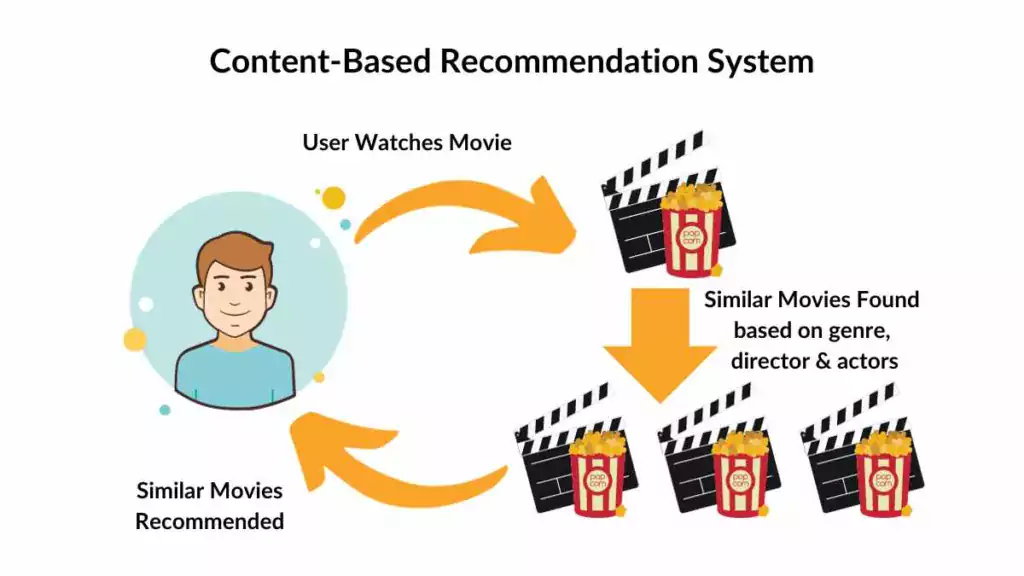

The **Content-Based Recommender**
relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

Below are the different steps to build a content-based recommender system:

<img src="img/content_flowchart.png" width="200">

### Step 1: Item feature Extraction

We are going to build a Content-Based Recommendation Engine that computes item features based on movie genres. We can then suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file **movies.csv**

In [ ]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split(_____) #Fill in the blank with the separator
movies['genres'] = movies['genres'].fillna("").astype('str') #Convert genres to string values
movies.head()

The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of soccer games is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

<img src="img/tfidf.png">

#### Implementation

We will use the **TfidfVectorizer** function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [ ]:
from sklearn.feature_extraction.text import ______ #Import the necessary function
tf = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), min_df=0.0) #analyzer: chars or words, min_df: minimum doc frequency
tfidf_matrix = tf.______(movies['genres']) #Fit and transform the genres
tfidf_matrix.shape

We will now calculate the **Cosine similarity** for every movie against every other movie in the dataset.

<img src="img/cs.png">

<img src="img/dm.png">

In [ ]:
from sklearn.metrics.pairwise import ________

# Calculate the cosine similarity matrix
cosine_sim = _______(tfidf_matrix, tfidf_matrix) #Fill in the blanks to calculate cosine similarity

In [5]:
# Function to get movie recommendations
def get_movie_recommendations(movie_title, movies_df, cosine_sim_matrix):
    # Get the index of the movie
    idx = movies_df.index[movies_df['title'] == movie_title].tolist()[0]
    
    # Get the similarity scores for this movie with all other movies
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    
    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top 10 similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:11]
    
    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 similar movies with their similarity scores
    recommendations = pd.DataFrame({
        'Title': movies_df['title'].iloc[movie_indices],
        'Similarity Score': [i[1] for i in sim_scores]
    })
    
    return recommendations

In [ ]:
# Example usage:
movie_recommendations = get_movie_recommendations("Toy Story (1995)", movies, cosine_sim)
print(movie_recommendations)

In [ ]:
# Example usage:
movie_recommendations = get_movie_recommendations("Matrix, The (1999)", movies, cosine_sim)
print(movie_recommendations)

### Step 2: User profile creation

A user can be represented as a an **average vector** of all the movies that the like. We can take a TF-IDF vector average, or even weigh the TF-IDF vectors of the movies that a user has watched based on the rating that they've given it.

For the sake of simplicity we will take simple average of the TF-IDF vectors for movies that a user has given a rating >= 4

In [7]:
def create_user_vector(user_id, ratings_df, movies_df, cosine_sim, min_rating=4):
    """
    Create user profile vector as average of movies they rated highly
    """
    # Get movies that user rated highly
    user_ratings = ratings_df[
        (ratings_df['user_id'] == user_id) & 
        (ratings_df['rating'] >= min_rating)
    ]
    
    if user_ratings.empty:
        return None
    
    # Get the indices of movies user liked
    movie_indices = []
    for movie_id in user_ratings['movie_id']:
        movie_idx = movies_df[movies_df['movie_id'] == movie_id].index
        if not movie_idx.____: # check if the index is empty
           ________ # Append the index 
    
    # Create user profile as average of movie vectors
    user_vector = cosine_sim[movie_indices].______(axis=____) #Calculate mean. Fill blanks.
    
    return user_vector

### Step 3: Similarity Calculation
Now that we have calculated a **representation of user**, we can calculate movies that are similar to a given users representation.

For this we calculate the **cosine similarity** between the user vector and the movies vector.

In [8]:
def get_recommendations_from_vector(user_vector, movies_df, cosine_sim, n=5):
    """
    Get movie recommendations based on similarity to user vector
    """
    # Calculate similarity between user vector and all movies
    sim_scores = list(enumerate(user_vector))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=_______, reverse=True) #Fill in the blank with sorting criteria

    # Get movie indices and scores
    movie_indices = [i[0] for i in sim_scores[:n]]
    similarity_scores = [i[1] for i in sim_scores[:n]]
    
    # Create recommendations dataframe
    recommendations = pd.DataFrame({
        'Title': movies_df['title'].iloc[movie_indices],
        'Genres': movies_df['genres'].iloc[movie_indices],
        'Similarity Score': similarity_scores
    })
    
    return recommendations

### Step 3: Generate Recommendations
We can now remove the movies that a user has already seen, and rank the other **similar** movies to the users vector based on the **similarity score**.

In [10]:
def recommend_movies(user_id, ratings_df, movies_df, cosine_sim, n=5):
    """
    Main function to get recommendations for a user
    """
    # Create user profile vector
    user_vector = create_user_vector(user_id, ratings_df, movies_df, cosine_sim)
    
    # Get recommendations
    recommendations = get_recommendations_from_vector(
        user_vector, 
        movies_df, 
        cosine_sim, 
        n=n
    )
    
    # Remove movies user has already rated
    rated_movies = set(ratings_df[
        ratings_df['user_id'] == user_id
    ]['movie_id'])

    recommendations = recommendations[
        ~recommendations['Title'].______(       # Negation
            movies_df[
                movies_df['movie_id'].isin(______) #Check if movie has been rated
            ]['title']
        )
    ]
    
    return recommendations

In [ ]:
user_id = 341

# Get recommendations
recommendations = ______( # Call the right function
    user_id, 
    ratings, 
    movies, 
    cosine_sim
)
print(f"\nRecommendations for User {user_id}:")
recommendations

In [98]:
#Let's look at the movies that user 341 has watched
combined[combined['user_id'] == 341][['user_id', 'title', 'genres', 'rating']]

,user_id,title,genres,rating
34192,341,Braveheart (1995),Action|Drama|War,5
87466,341,Tank Girl (1995),Action|Comedy|Musical|Sci-Fi,4
129191,341,Jurassic Park (1993),Action|Adventure|Sci-Fi,3
177776,341,Mission: Impossible (1996),Action|Adventure|Mystery,5
235270,341,East of Eden (1955),Drama,5
318215,341,Alien (1979),Action|Horror|Sci-Fi|Thriller,4
332933,341,"Boat, The (Das Boot) (1981)",Action|Drama|War,5
343721,341,Nikita (La Femme Nikita) (1990),Thriller,5
370346,341,Somewhere in Time (1980),Drama|Romance,5
445336,341,Contact (1997),Drama|Sci-Fi,4


In [97]:
from collections import Counter
# Convert to DataFrame
df341 = combined[combined['user_id'] == 341][['user_id', 'title', 'genres', 'rating']].sort_values('rating', ascending=False)

def analyze_genre_ratings(df, min_rating=4):
    # Filter for high ratings
    high_rated = df[df['rating'] >= min_rating]
    
    # Split genres and count occurrences
    genre_counts = Counter()
    for genres in high_rated['genres']:
        genre_list = genres.split('|')
        genre_counts.update(genre_list)
    
    # Convert to DataFrame for better visualization
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
    genre_df = genre_df.sort_values('count', ascending=False)
    
    return genre_df

# Analyze genres for movies rated 4 or higher
genre_distribution = analyze_genre_ratings(df1)
print("\nGenre distribution for movies rated 4 or higher:")
print(genre_distribution)


Genre distribution for movies rated 4 or higher:
           count
Action         8
Drama          7
Sci-Fi         4
Thriller       3
Comedy         3
War            2
Crime          2
Romance        2
Adventure      2
Mystery        1
Horror         1
Musical        1


Overall, here are the **pros** of using content-based recommendation:

- No need for data on other users, thus no cold-start or sparsity problems.
- Can recommend to users with unique tastes.
- Can recommend new & unpopular items.
- Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)
  
However, there are some **cons** of using this approach:

- Finding the appropriate features is hard.
- Does not recommend items outside a user's content profile.
- Unable to exploit quality judgments of other users.

In [99]:
users

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,25-34,scientist
6036,6037,F,45,1,76006,45-49,academic/educator
6037,6038,F,56,1,14706,56+,academic/educator
6038,6039,F,45,0,01060,45-49,other or not specified
